In [ ]:
# Francisco Dominguez Mateos
# 25/06/2020
# from: https://github.com/google/jax/blob/master/examples/advi.py

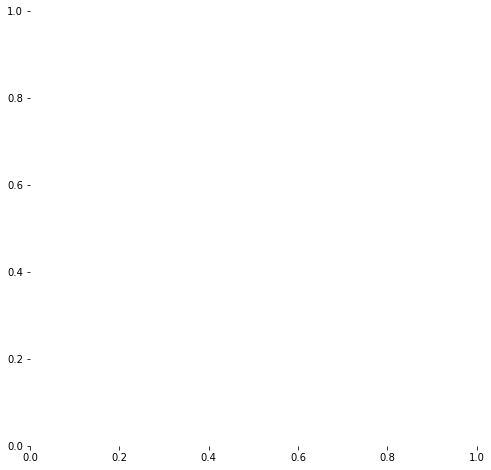

/home/francisco/anaconda3/envs/jax/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Optimizing variational parameters...
Iteration 0 lower bound 0.4957694113254547


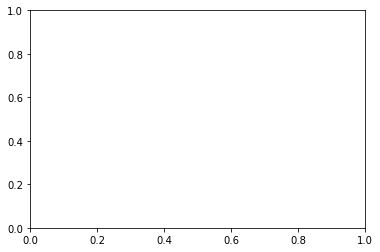

Iteration 1 lower bound 1.0041999816894531


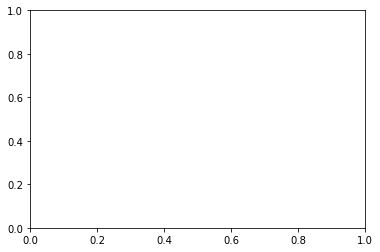

Iteration 2 lower bound 1.7300430536270142


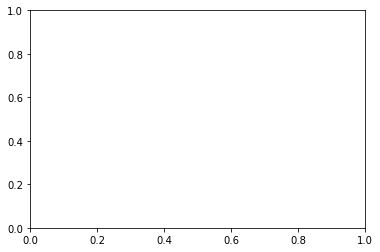

Iteration 3 lower bound 2.3629071712493896


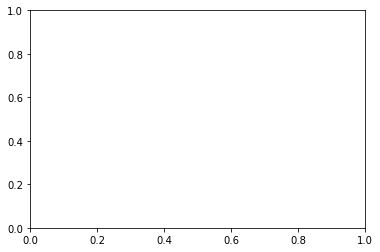

Iteration 4 lower bound 2.168174982070923


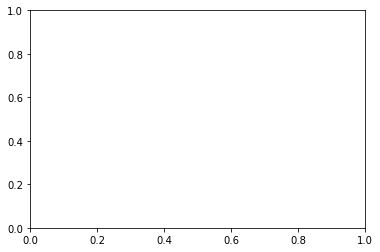

Iteration 5 lower bound 1.9193592071533203


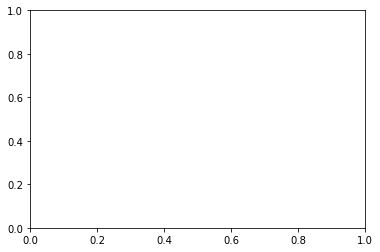

Iteration 6 lower bound 1.1959587335586548


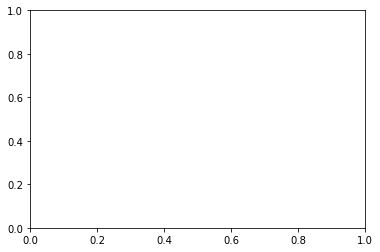

Iteration 7 lower bound 1.1514695882797241


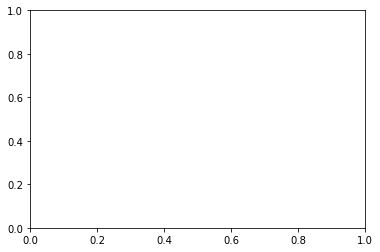

Iteration 8 lower bound 1.367148756980896


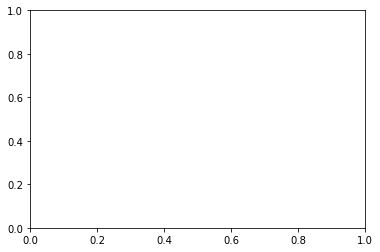

Iteration 9 lower bound 1.3308906555175781


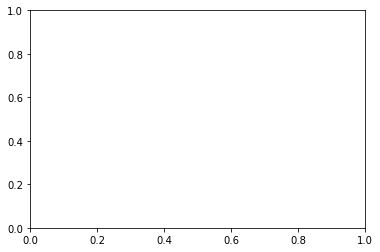

Iteration 10 lower bound 0.6655112504959106


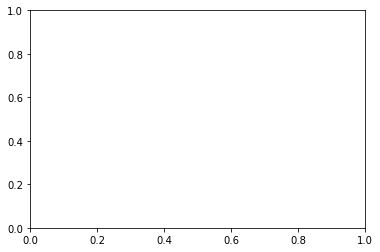

Iteration 11 lower bound 0.7310014963150024


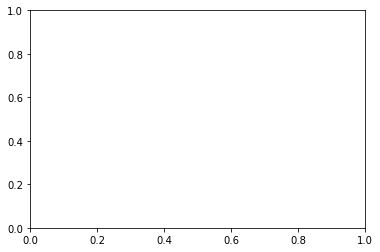

Iteration 12 lower bound 0.9544447064399719


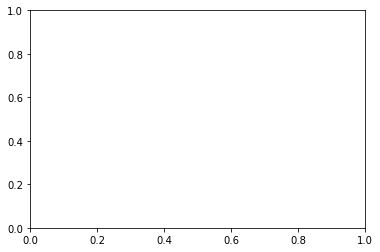

Iteration 13 lower bound 1.3851865530014038


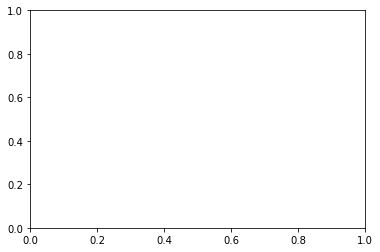

Iteration 14 lower bound 1.3394533395767212


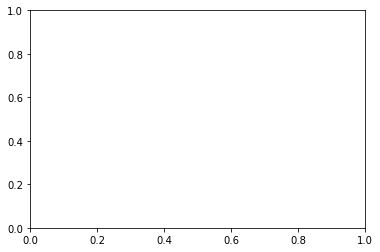

Iteration 15 lower bound 1.1026709079742432


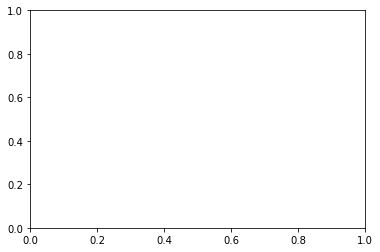

Iteration 16 lower bound 1.3372206687927246


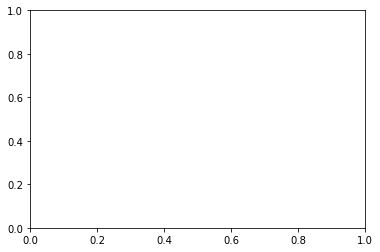

Iteration 17 lower bound 1.168276309967041


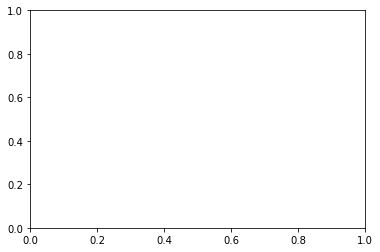

Iteration 18 lower bound 1.0563621520996094


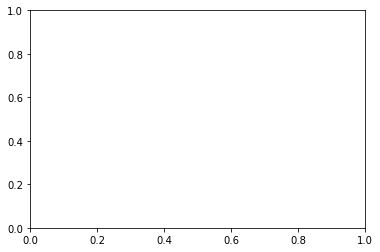

Iteration 19 lower bound 0.793488621711731


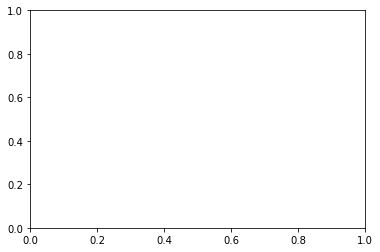

Iteration 20 lower bound 0.8373391032218933


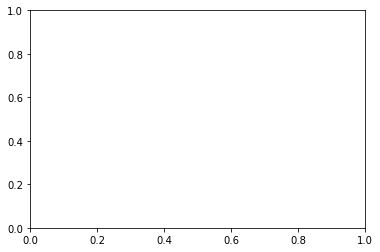

Iteration 21 lower bound 0.8123655319213867


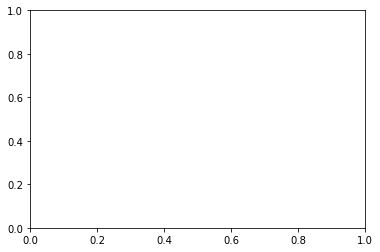

Iteration 22 lower bound 0.9565300941467285


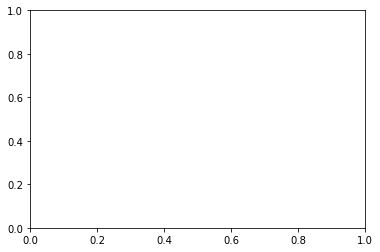

Iteration 23 lower bound 1.2810070514678955


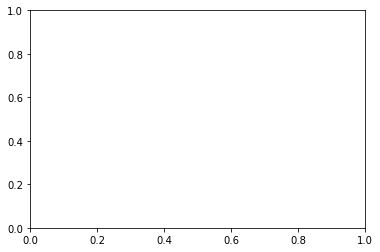

Iteration 24 lower bound 1.3535046577453613


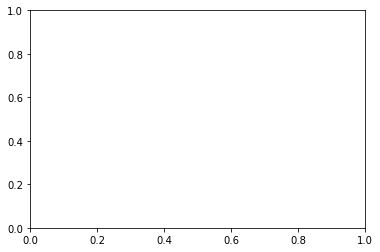

Iteration 25 lower bound 1.148445963859558


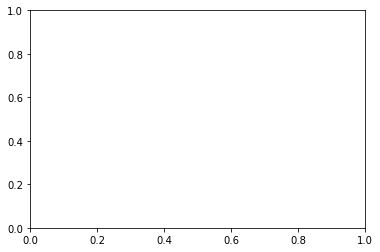

Iteration 26 lower bound 0.9616872072219849


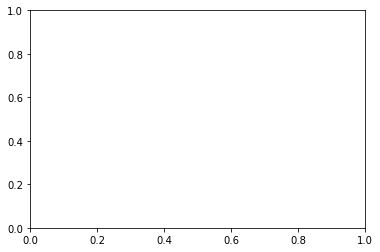

Iteration 27 lower bound 0.9995042681694031


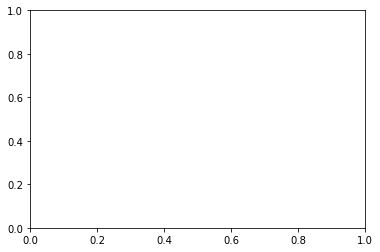

Iteration 28 lower bound 1.058048963546753


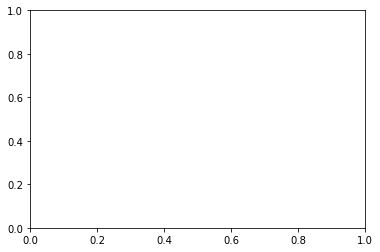

Iteration 29 lower bound 1.0087686777114868


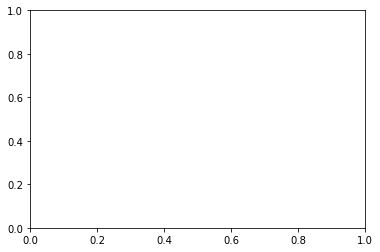

Iteration 30 lower bound 1.3392294645309448


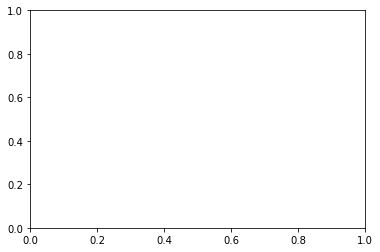

Iteration 31 lower bound 0.9552570581436157


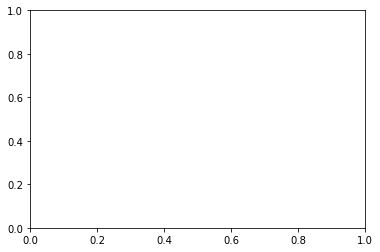

Iteration 32 lower bound 0.6129273772239685


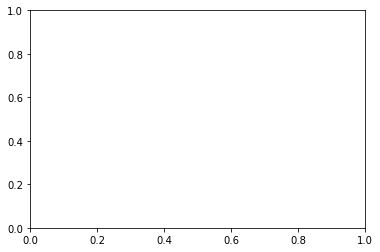

Iteration 33 lower bound 1.1010332107543945


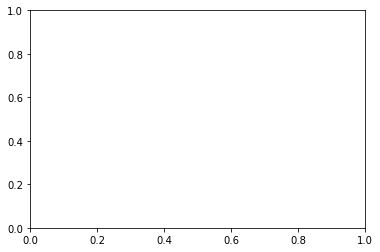

Iteration 34 lower bound 0.9531831741333008


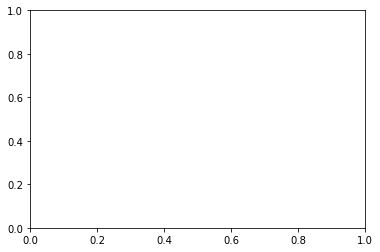

Iteration 35 lower bound 1.1605361700057983


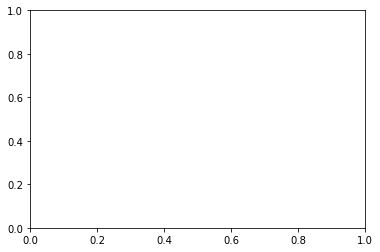

Iteration 36 lower bound 0.8258180618286133


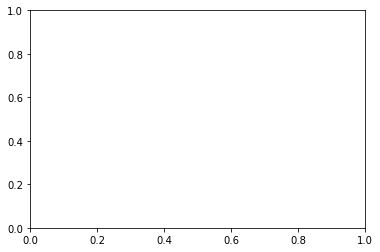

Iteration 37 lower bound 1.2801016569137573


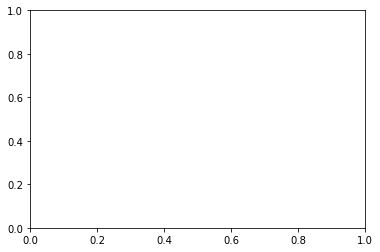

Iteration 38 lower bound 0.9199051856994629


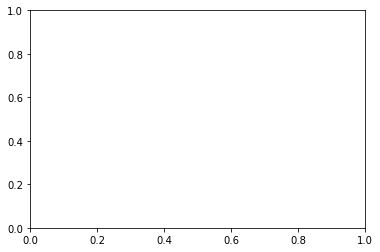

Iteration 39 lower bound 1.190202236175537


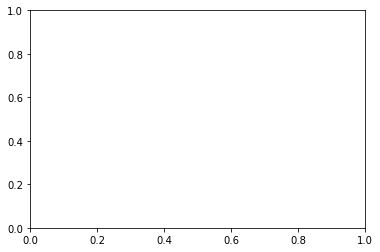

Iteration 40 lower bound 1.8397754430770874


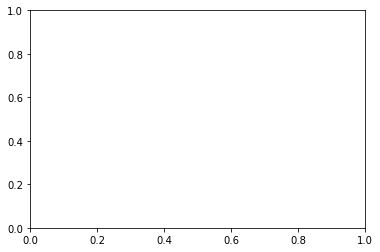

Iteration 41 lower bound 1.4406404495239258


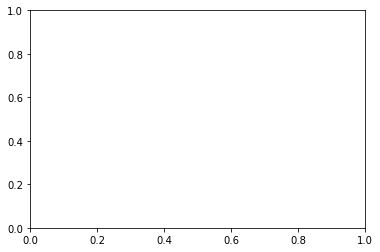

Iteration 42 lower bound 1.2906240224838257


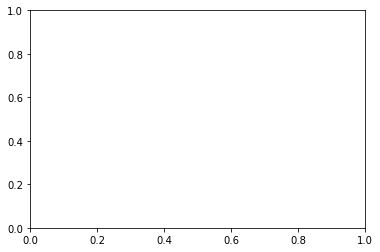

Iteration 43 lower bound 0.7370042204856873


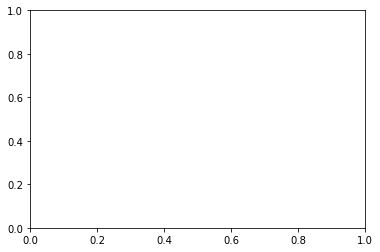

Iteration 44 lower bound 0.6765009760856628


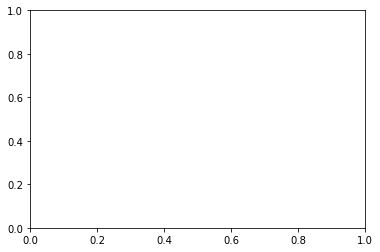

Iteration 45 lower bound 0.9893814325332642


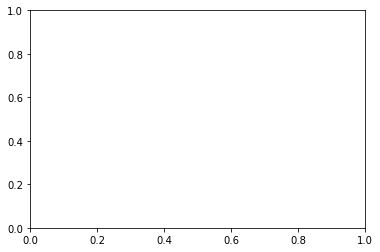

Iteration 46 lower bound 0.7622580528259277


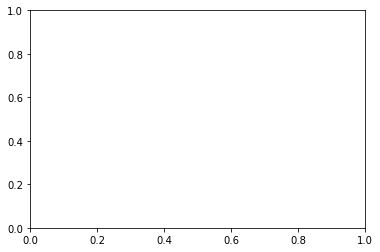

Iteration 47 lower bound 1.8616338968276978


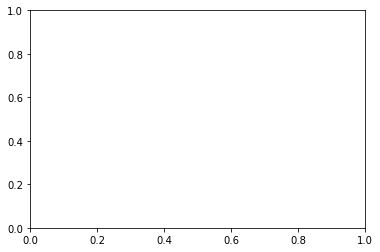

Iteration 48 lower bound 3.9939472675323486


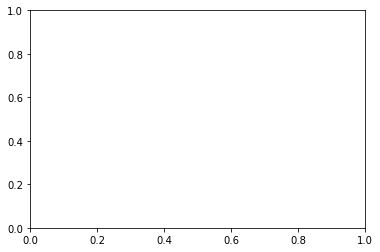

Iteration 49 lower bound 4.806173801422119


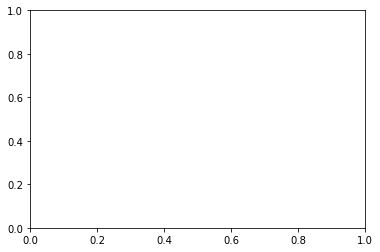

Iteration 50 lower bound 5.067562103271484


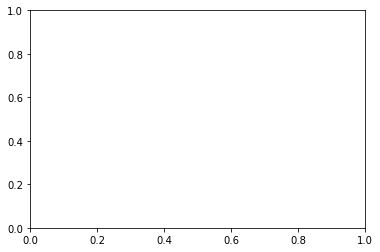

Iteration 51 lower bound 5.3409647941589355


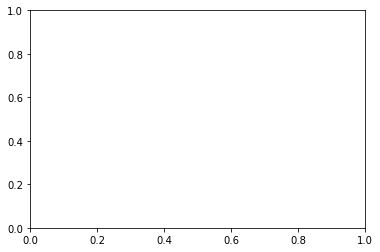

Iteration 52 lower bound 4.733808994293213


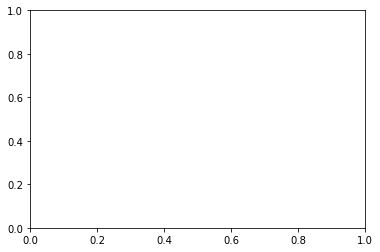

Iteration 53 lower bound 4.037384510040283


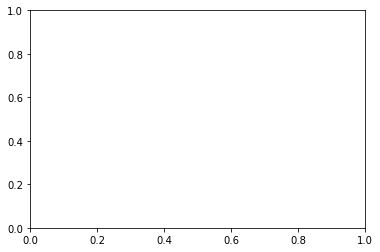

Iteration 54 lower bound 3.355987548828125


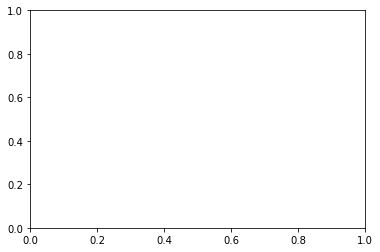

Iteration 55 lower bound 3.112006425857544


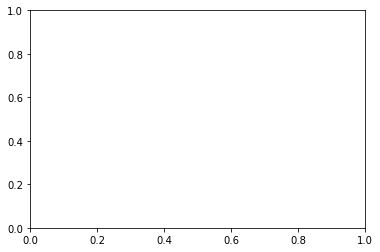

Iteration 56 lower bound 3.222581624984741


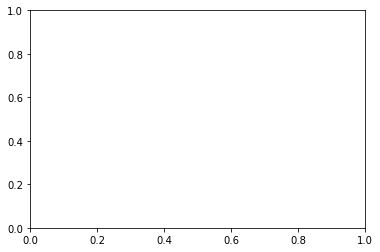

Iteration 57 lower bound 2.010301351547241


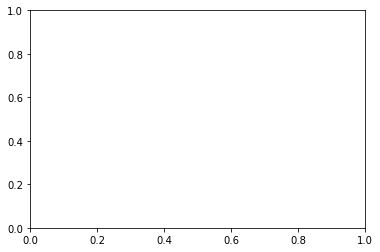

Iteration 58 lower bound 1.606302261352539


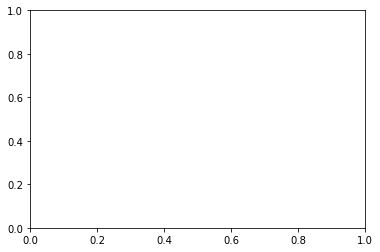

Iteration 59 lower bound 1.3691803216934204


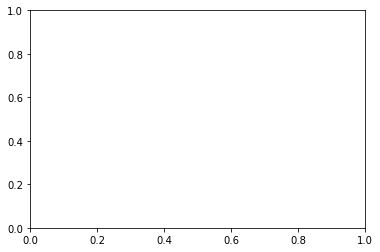

Iteration 60 lower bound 1.3163694143295288


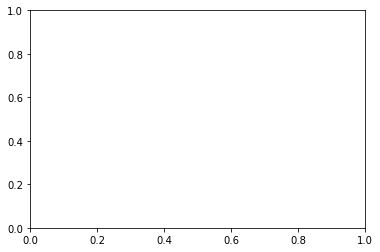

Iteration 61 lower bound 1.1717389822006226


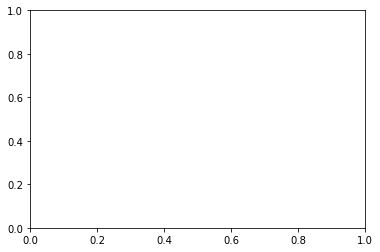

Iteration 62 lower bound 1.150301218032837


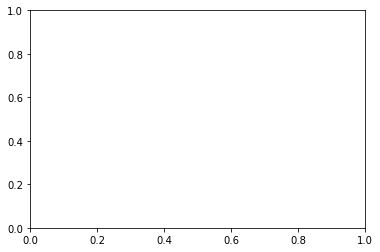

Iteration 63 lower bound 1.9096695184707642


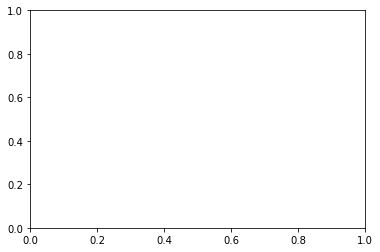

Iteration 64 lower bound 2.5290443897247314


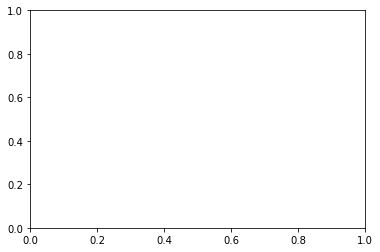

Iteration 65 lower bound 4.1317033767700195


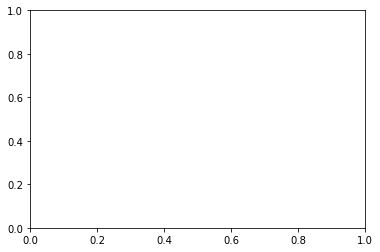

Iteration 66 lower bound 4.558084011077881


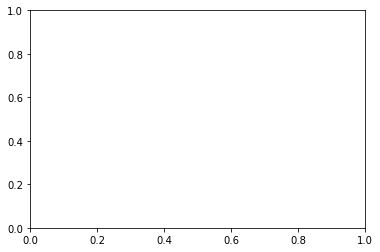

Iteration 67 lower bound 4.537883281707764


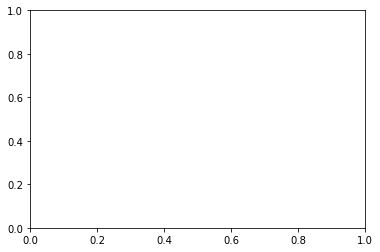

Iteration 68 lower bound 4.171029567718506


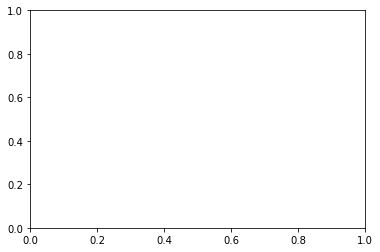

Iteration 69 lower bound 4.033625602722168


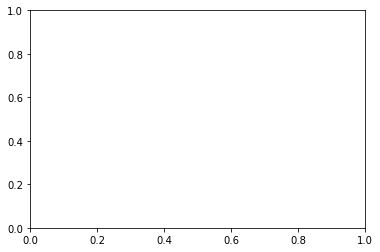

Iteration 70 lower bound 4.959519863128662


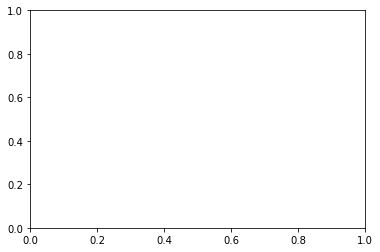

Iteration 71 lower bound 5.092325687408447


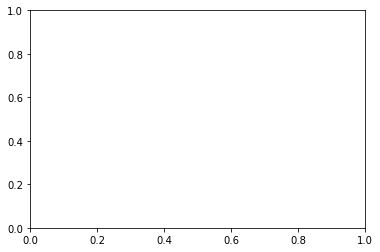

Iteration 72 lower bound 3.7729642391204834


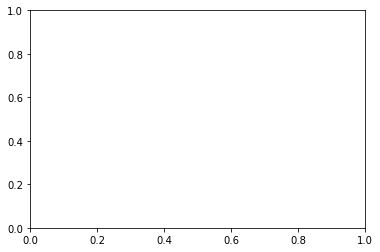

Iteration 73 lower bound 3.6047425270080566


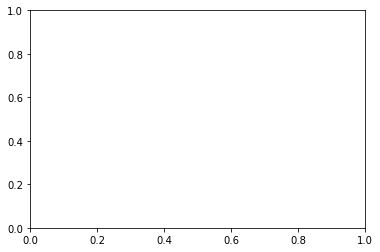

Iteration 74 lower bound 3.733430862426758


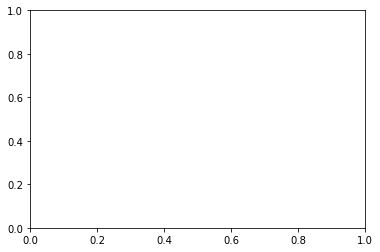

Iteration 75 lower bound 3.307220458984375


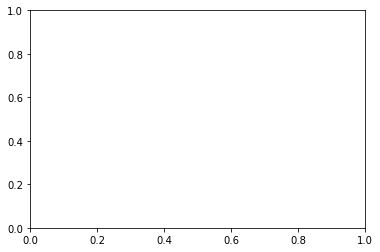

Iteration 76 lower bound 2.536059617996216


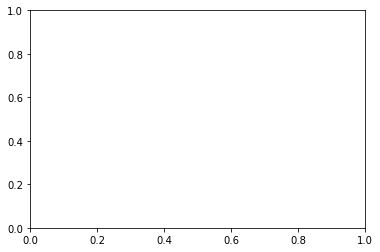

Iteration 77 lower bound 2.2490861415863037


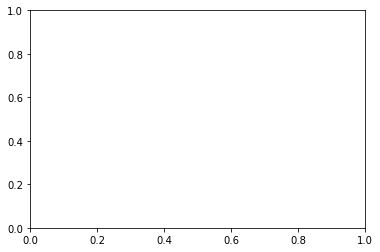

Iteration 78 lower bound 2.2384793758392334


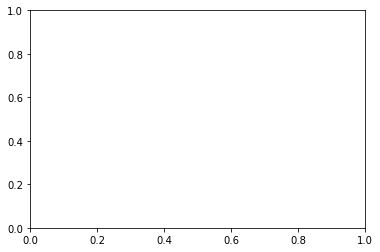

Iteration 79 lower bound 1.9689159393310547


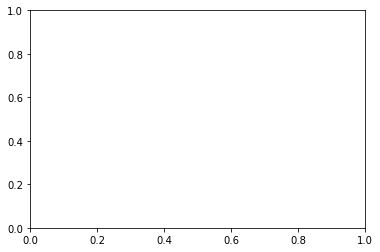

Iteration 80 lower bound 6.256234169006348


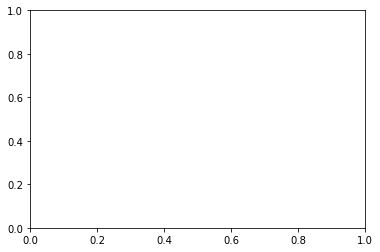

Iteration 81 lower bound 13.173898696899414


/home/francisco/anaconda3/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.


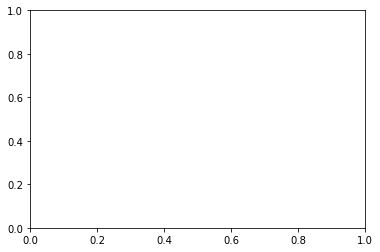

Iteration 82 lower bound 18.146326065063477


/home/francisco/anaconda3/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.


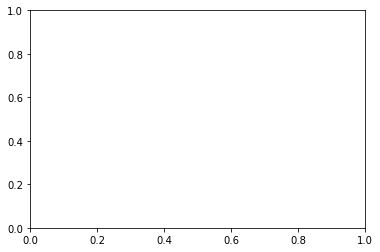

Iteration 83 lower bound 21.280073165893555


/home/francisco/anaconda3/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.


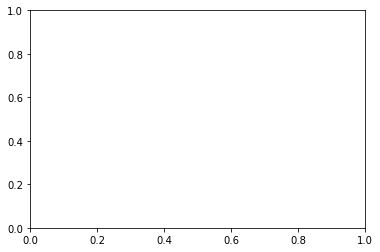

Iteration 84 lower bound 21.960886001586914


/home/francisco/anaconda3/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.


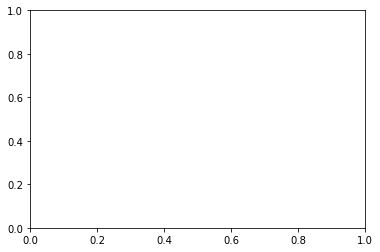

Iteration 85 lower bound 20.914308547973633


/home/francisco/anaconda3/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.


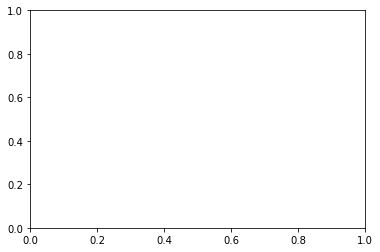

Iteration 86 lower bound 19.108564376831055


/home/francisco/anaconda3/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.


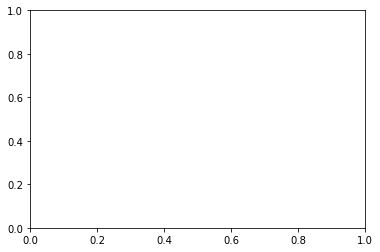

Iteration 87 lower bound 16.3676815032959


/home/francisco/anaconda3/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.


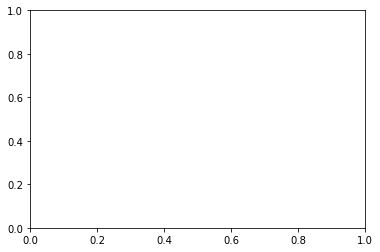

Iteration 88 lower bound 13.818011283874512


/home/francisco/anaconda3/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.


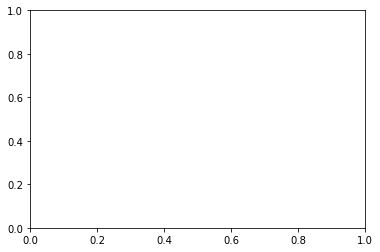

Iteration 89 lower bound 12.860259056091309


/home/francisco/anaconda3/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.


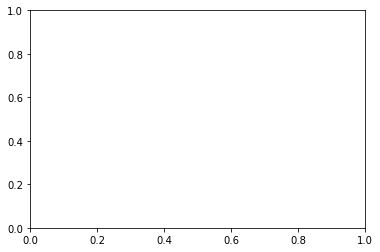

Iteration 90 lower bound 19.051420211791992


/home/francisco/anaconda3/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.


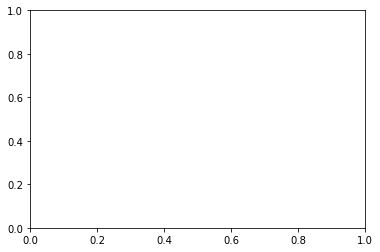

Iteration 91 lower bound 11.713276863098145


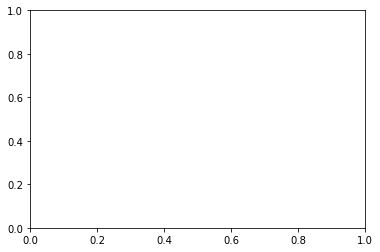

Iteration 92 lower bound 11.079428672790527


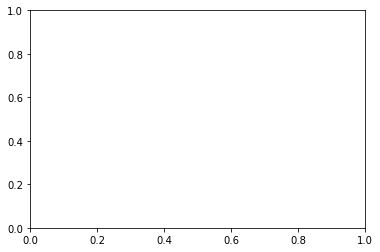

Iteration 93 lower bound 11.265055656433105


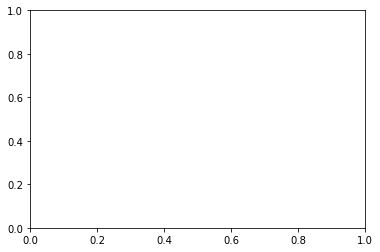

Iteration 94 lower bound 11.01016902923584


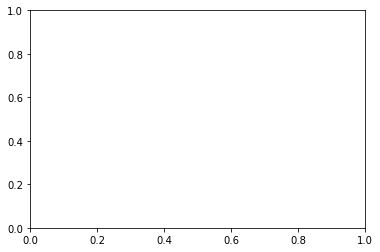

Iteration 95 lower bound 10.213011741638184


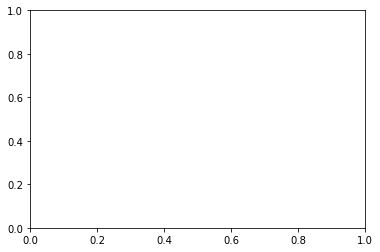

Iteration 96 lower bound 8.766847610473633


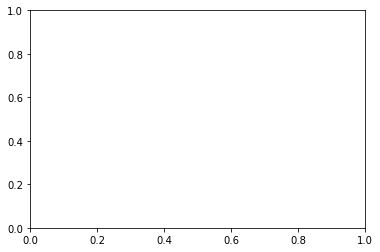

Iteration 97 lower bound 7.34255838394165


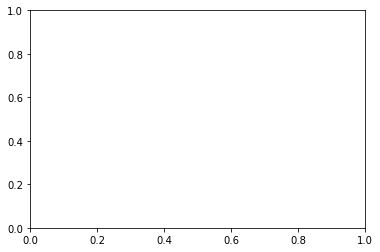

Iteration 98 lower bound 6.029675483703613


/home/francisco/anaconda3/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.


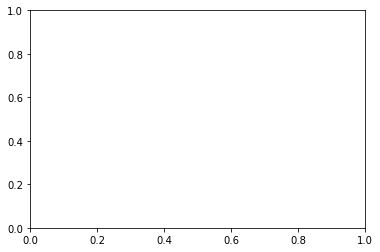

Iteration 99 lower bound 5.908818244934082


/home/francisco/anaconda3/envs/jax/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.


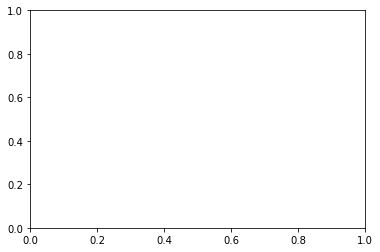

In [1]:
# Copyright 2018 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Automatic differentiation variational inference in Numpy and JAX.
This demo fits a Gaussian approximation to an intractable, unnormalized
density, by differentiating through a Monte Carlo estimate of the
variational evidence lower bound (ELBO)."""


from functools import partial
import matplotlib.pyplot as plt

from jax.api import jit, grad, vmap
from jax import random
from jax.experimental import optimizers
import jax.numpy as jnp
import jax.scipy.stats.norm as norm


# ========= Functions to define the evidence lower bound. =========

def diag_gaussian_sample(rng, mean, log_std):
    # Take a single sample from a diagonal multivariate Gaussian.
    return mean + jnp.exp(log_std) * random.normal(rng, mean.shape)

def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate a single point on a diagonal multivariate Gaussian.
    return jnp.sum(vmap(norm.logpdf)(x, mean, jnp.exp(log_std)))

def elbo(logprob, rng, mean, log_std):
    # Single-sample Monte Carlo estimate of the variational lower bound.
    sample = diag_gaussian_sample(rng, mean, log_std)
    return logprob(sample) - diag_gaussian_logpdf(sample, mean, log_std)

def batch_elbo(logprob, rng, params, num_samples):
    # Average over a batch of random samples.
    rngs = random.split(rng, num_samples)
    vectorized_elbo = vmap(partial(elbo, logprob), in_axes=(0, None, None))
    return jnp.mean(vectorized_elbo(rngs, *params))


# ========= Helper function for plotting. =========

@partial(jit, static_argnums=(0, 1, 2, 4))
def _mesh_eval(func, x_limits, y_limits, params, num_ticks):
    # Evaluate func on a 2D grid defined by x_limits and y_limits.
    x = jnp.linspace(*x_limits, num=num_ticks)
    y = jnp.linspace(*y_limits, num=num_ticks)
    X, Y = jnp.meshgrid(x, y)
    xy_vec = jnp.stack([X.ravel(), Y.ravel()]).T
    zs = vmap(func, in_axes=(0, None))(xy_vec, params)
    return X, Y, zs.reshape(X.shape)

def mesh_eval(func, x_limits, y_limits, params, num_ticks=101):
    return _mesh_eval(func, x_limits, y_limits, params, num_ticks)

# ========= Define an intractable unnormalized density =========

def funnel_log_density(params):
    return norm.logpdf(params[0], 0, jnp.exp(params[1])) + \
           norm.logpdf(params[1], 0, 1.35)


if __name__ == "__main__":
    num_samples = 40

    @jit
    def objective(params, t):
        rng = random.PRNGKey(t)
        return -batch_elbo(funnel_log_density, rng, params, num_samples)

    # Set up figure.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    plt.ion()
    plt.show(block=False)
    x_limits = [-2, 2]
    y_limits = [-4, 2]
    target_dist = lambda x, _: jnp.exp(funnel_log_density(x))
    approx_dist = lambda x, params: jnp.exp(diag_gaussian_logpdf(x, *params))

    def callback(params, t):
        print("Iteration {} lower bound {}".format(t, objective(params, t)))

        plt.cla()
        X, Y, Z = mesh_eval(target_dist, x_limits, y_limits, 1)
        ax.contour(X, Y, Z, cmap='summer')
        X, Y, Z = mesh_eval(approx_dist, x_limits, y_limits, params)
        ax.contour(X, Y, Z, cmap='winter')
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)
        ax.set_yticks([])
        ax.set_xticks([])

        # Plot random samples from variational distribution.
        # Here we clone the rng used in computing the objective
        # so that we can show exactly the same samples.
        rngs = random.split(random.PRNGKey(t), num_samples)
        samples = vmap(diag_gaussian_sample, in_axes=(0, None, None))(rngs, *params)
        ax.plot(samples[:, 0], samples[:, 1], 'b.')

        plt.draw()
        plt.pause(1.0/60.0)


    # Set up optimizer.
    D = 2
    init_mean = jnp.zeros(D)
    init_std  = jnp.zeros(D)
    init_params = (init_mean, init_std)
    opt_init, opt_update, get_params = optimizers.momentum(step_size=0.1, mass=0.9)
    opt_state = opt_init(init_params)

    @jit
    def update(i, opt_state):
        params = get_params(opt_state)
        gradient = grad(objective)(params, i)
        return opt_update(i, gradient, opt_state)


    # Main loop.
    print("Optimizing variational parameters...")
    for t in range(100):
        opt_state = update(t, opt_state)
        params = get_params(opt_state)
        callback(params, t)
    plt.show(block=True)